In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset, TensorDataset
from torchvision import transforms, models

from torchvision.transforms import ToTensor



# Helper libraries
from torchsummary import summary
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import pandas as pd
from PIL import Image



!nvidia-smi | grep GeForce
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/bin/nvidia-smi: line 2: nvidia-smi.lanigiro: command not found


In [ ]:
def load_dataset():
    dirname = '/scratch-shared/students/DeepLearning/bbbc021v1_images'
    x_orig = torch.zeros((660, 3, 256, 256), dtype=torch.float32)

    for f in range(x_orig.shape[0]):
        img = Image.open(dirname + '/bbbc021v1_%s.png' % str(f))
        # img = img.convert('RGB')
        img = np.array(img).transpose(2, 0, 1)
        img = torch.tensor(img)
        x_orig[f] = img

    labels = pd.read_csv('/scratch-shared/students/lmm-student-main/bbbc021v1_labels.csv',
                      usecols=["compound", "concentration", "moa"],
                      sep=";")

    y_orig = np.array(labels['moa'])

    return x_orig, y_orig

In [ ]:
def convert_to_one_hot(y, C):
    moa_dict = {'Aurora kinase inhibitors': 0, 'Cholesterol-lowering': 1,
                'Eg5 inhibitors': 2, 'Protein synthesis': 3, 'DNA replication': 4, 'DNA damage': 5}

    y = np.asarray([moa_dict[item] for item in y])

    y = torch.tensor(y, dtype=torch.int64)
    return y

In [4]:

def plot_history(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    epochs = len(train_losses)
    
    fig = plt.figure(figsize=(15, 5), facecolor='w')
    
    ax = fig.add_subplot(131)
    ax.plot(range(1, epochs+1), train_losses, label='Train')
    ax.plot(range(1, epochs+1), val_losses, label='Validation')
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(loc='upper right')
    
    ax = fig.add_subplot(132)
    ax.plot(range(1, epochs+1), np.log(train_losses), label='Train')
    ax.plot(range(1, epochs+1), np.log(val_losses), label='Validation')
    ax.set(title=model_name + ': Log model loss', ylabel='Log loss', xlabel='Epoch')
    ax.legend(loc='upper right')
    
    ax = fig.add_subplot(133)
    ax.plot(range(1, epochs+1), train_accuracies, label='Train')
    ax.plot(range(1, epochs+1), val_accuracies, label='Validation')
    ax.set(title=model_name + ': Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    ax.legend(loc='lower right')
    
    plt.show()
    plt.close()

In [5]:
def plot_confusion_matrix(cm, classes, model_name, cmap=plt.cm.Blues):
    title = model_name + ': Confusion Matrix'
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
def valid_evaluate(model, valid_loader, model_name, num_classes=6):
    model.eval()
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            # predicted = torch.nn.functional.one_hot(predicted, num_classes)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    class_names = ['Aur', 'Ch', 'Eg5', 'PS', 'DR', 'DS']
    # print(f'y pred {y_pred}')
    # print(f'y_tru {y_true}')

    # y_true = [torch.tensor(label).argmax().item() for label in y_true]
    # y_pred = [torch.tensor(pred).argmax().item() for pred in y_pred]
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    
    plt.figure(figsize=(15,5), facecolor='w')
    plot_confusion_matrix(cnf_matrix, classes=class_names, model_name=model_name)
    plt.show()
    plt.close()
    
    print('')
    print('Classification report for validation data:')
    print(classification_report(y_true, y_pred, digits=3, target_names=class_names))

In [ ]:
def test_evaluate(model, test_loader, model_name, num_classes=6):
    model.eval()
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  
            true_labels = labels.argmax(dim=1) if labels.dim() > 1 else labels
            y_true.extend(true_labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())


    class_names = ['Aur', 'Ch', 'Eg5', 'PS', 'DR', 'DS']
    
    # confusion
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    plt.figure(figsize=(15, 5), facecolor='w')
    plot_confusion_matrix(cnf_matrix, classes=class_names, model_name=model_name)
    plt.show()
    plt.close()
    

    print('')
    print('Classification report for test data:')
    print(classification_report(y_true, y_pred, digits=3, target_names=class_names))


In [ ]:
X_orig, y_orig = load_dataset()
Y = convert_to_one_hot(y_orig, 6)  # one-hot
X = X_orig / 255.0  # normalization

total_samples = len(Y)
print(f"Total samples: {total_samples}")


n_train = 528  
n_valid = int((total_samples - n_train) * 0.5)  
n_test = total_samples - n_train - n_valid  


random.seed(5026)
indices = np.arange(total_samples)
random.shuffle(indices)

# Split Dataset
X_train = X[indices[:n_train]]
Y_train = Y[indices[:n_train]]

X_valid = X[indices[n_train:n_train + n_valid]]
Y_valid = Y[indices[n_train:n_train + n_valid]]

X_test = X[indices[n_train + n_valid:]]
Y_test = Y[indices[n_train + n_valid:]]

# Convert to TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
valid_dataset = TensorDataset(X_valid, Y_valid)
test_dataset = TensorDataset(X_test, Y_test)


print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total samples: 660
Train set size: 528
Validation set size: 66
Test set size: 66


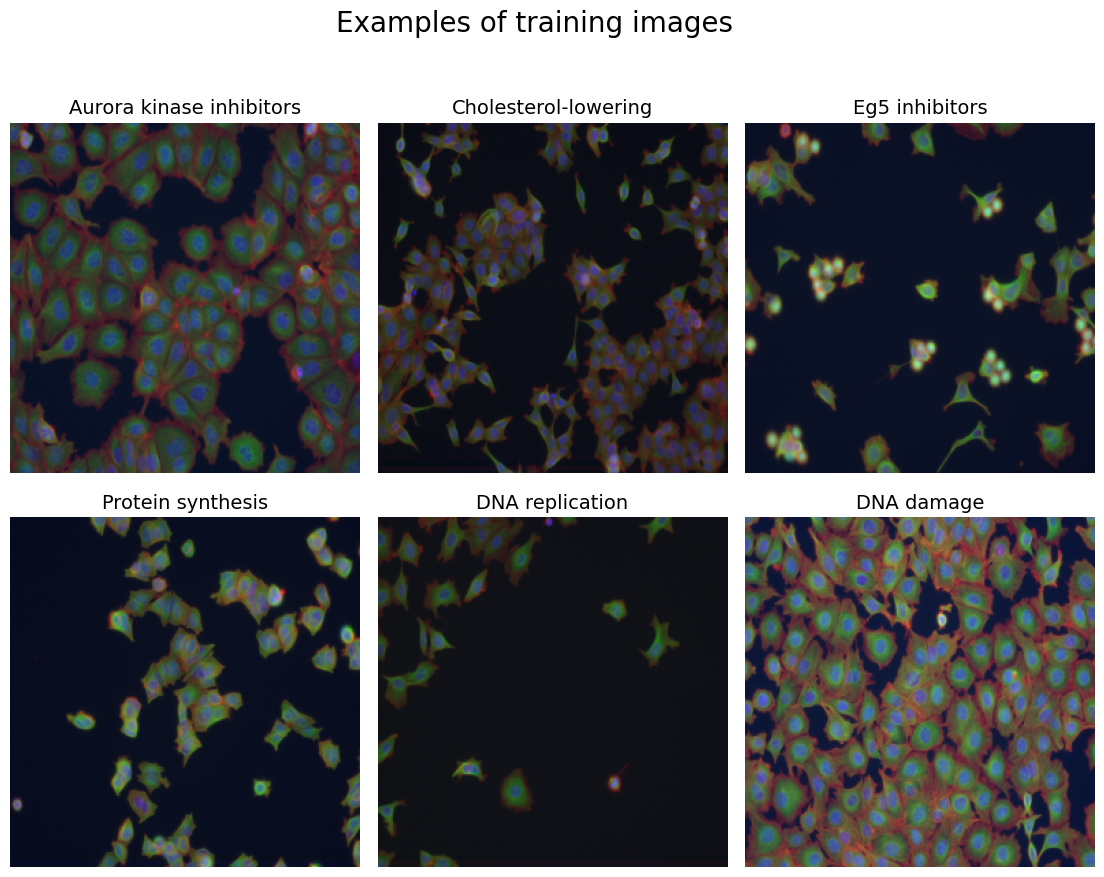

In [ ]:
# Run cell to plot few example images of the training set
fig, ax = plt.subplots(2, 3, figsize=(14, 10))
fig.suptitle("Examples of training images", fontsize=20)
axes = ax.ravel()
for i in range(len(axes)):
    # idx = np.where(np.argmax(Y_train, axis=1) == i)[0]
    idx = np.where(Y_train == i)[0]
    s_idx = np.random.choice(idx)
    imgt = X_train[s_idx].numpy()
    imgt = imgt.transpose(1, 2, 0)
    img = (imgt*255).astype("uint8")
    axes[i].set_title(y_orig[indices][s_idx], fontsize=14)
    axes[i].imshow(img)
    axes[i].set_axis_off()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
plt.close()

In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes=6):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  
        self.bn3 = nn.BatchNorm2d(64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128) 
        self.dropout = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        x = self.dropout(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxpool2(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
num_classes = 6
LeNet_model = LeNet(num_classes)
input_size = X_train.shape[1:]  
LeNet_model = LeNet_model.to(device).float()
from torchsummary import summary
summary(LeNet_model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]           1,216
       BatchNorm2d-2         [-1, 16, 256, 256]              32
              ReLU-3         [-1, 16, 256, 256]               0
         MaxPool2d-4         [-1, 16, 128, 128]               0
           Dropout-5         [-1, 16, 128, 128]               0
            Conv2d-6         [-1, 32, 128, 128]          12,832
       BatchNorm2d-7         [-1, 32, 128, 128]              64
              ReLU-8         [-1, 32, 128, 128]               0
         MaxPool2d-9           [-1, 32, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          18,496
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
        MaxPool2d-13           [-1, 64, 32, 32]               0
          Flatten-14                [-1

In [ ]:
class_counts = np.bincount(Y_train, minlength=6) 
class_names = ['Aur', 'Ch', 'Eg5', 'PS', 'DR', 'DS']
print("Training set class distribution:")
for class_idx, count in enumerate(class_counts):
    print(f"Class {class_names[class_idx]}: {count} samples")

Training set class distribution:
Class Aur: 122 samples
Class Ch: 63 samples
Class Eg5: 111 samples
Class PS: 81 samples
Class DR: 71 samples
Class DS: 80 samples


In [ ]:
class_counts = [122, 63, 111, 81, 71, 80]
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights ** 0.4  # 减小权重差异
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights = class_weights.to(device)
print("Adjusted class weights:", class_weights.tolist())

Adjusted class weights: [0.8639593720436096, 1.12538480758667, 0.8972388505935669, 1.0177550315856934, 1.072837471961975, 1.022824764251709]


In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
# data augumentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
valid_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset.transform = train_transforms
valid_dataset.transform = valid_transforms
test_dataset.transform = valid_transforms

# oversample
sample_weights = np.zeros(len(Y_train))
for i, label in enumerate(Y_train):
    sample_weights[i] = class_weights[label].item() ** 0.5
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)


In [ ]:

num_classes = 6
LeNet_model = LeNet(num_classes).to(device).float()

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(LeNet_model.parameters(), lr=0.001, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


num_epochs = 60
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)  
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

best_val_loss = float('inf')


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    LeNet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = LeNet_model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    LeNet_model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = LeNet_model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_loss /= len(valid_loader)
    val_losses.append(valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    val_accuracies.append(valid_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.2f}% - Valid Loss: {valid_loss:.4f} - Valid Acc: {valid_accuracy:.2f}%")

    scheduler.step(valid_loss)

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        torch.save(LeNet_model.state_dict(), 'best_model.pth')



Epoch [1/60] - Train Loss: 5.3618 - Train Acc: 25.00% - Valid Loss: 1.5597 - Valid Acc: 27.27%
Epoch [2/60] - Train Loss: 1.5493 - Train Acc: 31.06% - Valid Loss: 1.3144 - Valid Acc: 46.97%
Epoch [3/60] - Train Loss: 1.4279 - Train Acc: 34.85% - Valid Loss: 1.5989 - Valid Acc: 34.85%
Epoch [4/60] - Train Loss: 1.4764 - Train Acc: 33.52% - Valid Loss: 1.1311 - Valid Acc: 46.97%
Epoch [5/60] - Train Loss: 1.4211 - Train Acc: 34.85% - Valid Loss: 1.3947 - Valid Acc: 33.33%
Epoch [6/60] - Train Loss: 1.4397 - Train Acc: 36.74% - Valid Loss: 1.0260 - Valid Acc: 45.45%
Epoch [7/60] - Train Loss: 1.4771 - Train Acc: 32.77% - Valid Loss: 1.2784 - Valid Acc: 36.36%
Epoch [8/60] - Train Loss: 1.4258 - Train Acc: 36.74% - Valid Loss: 1.1327 - Valid Acc: 57.58%
Epoch [9/60] - Train Loss: 1.3721 - Train Acc: 40.34% - Valid Loss: 1.3754 - Valid Acc: 28.79%
Epoch [10/60] - Train Loss: 1.4284 - Train Acc: 38.45% - Valid Loss: 1.4603 - Valid Acc: 39.39%
Epoch [11/60] - Train Loss: 1.4227 - Train Acc: 3

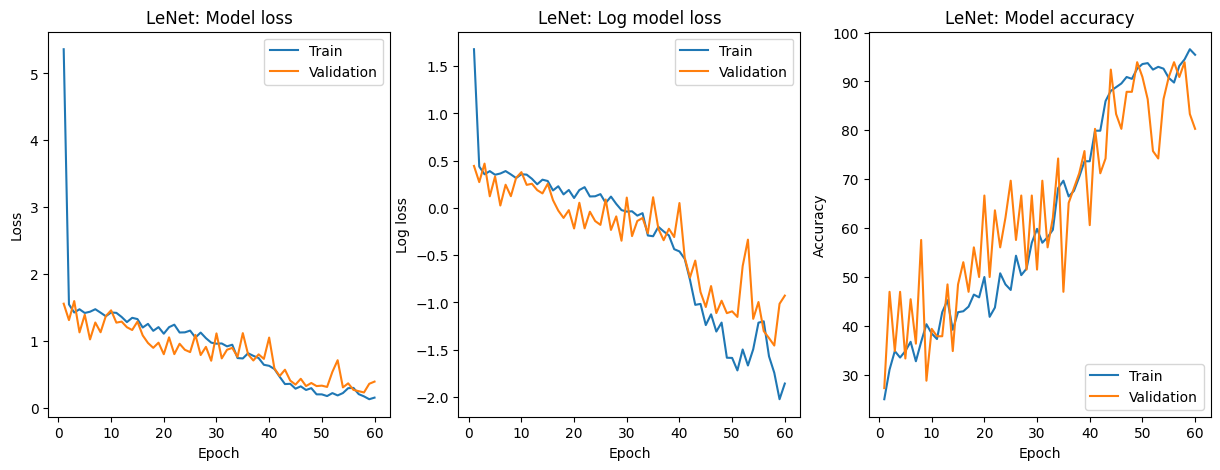

In [32]:
plot_history(train_losses, val_losses, train_accuracies, val_accuracies, "LeNet")

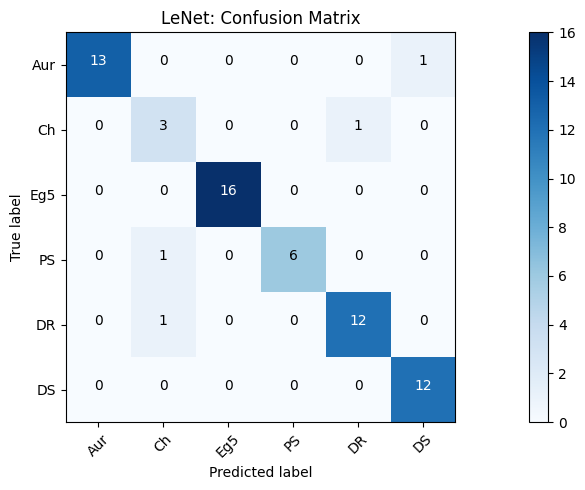


Classification report for validation data:
              precision    recall  f1-score   support

         Aur      1.000     0.929     0.963        14
          Ch      0.600     0.750     0.667         4
         Eg5      1.000     1.000     1.000        16
          PS      1.000     0.857     0.923         7
          DR      0.923     0.923     0.923        13
          DS      0.923     1.000     0.960        12

    accuracy                          0.939        66
   macro avg      0.908     0.910     0.906        66
weighted avg      0.947     0.939     0.941        66



In [33]:
valid_evaluate(LeNet_model, valid_loader, "LeNet")

/tmp/ipykernel_48042/3621874786.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  LeNet_model.load_state_dict(torch.load('best_model.pth'))


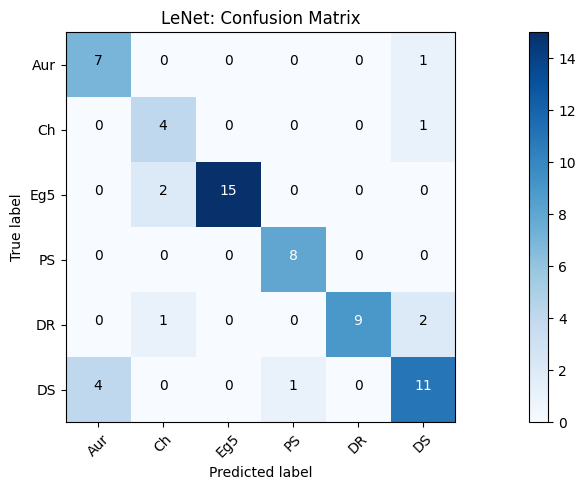


Classification report for test data:
              precision    recall  f1-score   support

         Aur      0.636     0.875     0.737         8
          Ch      0.571     0.800     0.667         5
         Eg5      1.000     0.882     0.938        17
          PS      0.889     1.000     0.941         8
          DR      1.000     0.750     0.857        12
          DS      0.733     0.688     0.710        16

    accuracy                          0.818        66
   macro avg      0.805     0.832     0.808        66
weighted avg      0.845     0.818     0.823        66



In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)
LeNet_model.load_state_dict(torch.load('best_model.pth'))
test_evaluate(LeNet_model, test_loader, model_name="LeNet", num_classes=6)